##### Data Modelling
Understanding, preparing, and modelling the future financial performance of a company (as measured by its revenue growth) based on its past financial performance. 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pprint import PrettyPrinter
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
pp = PrettyPrinter(indent=4)

In [3]:
combined = pd.read_csv('combined_data.csv', index_col=0)
combined = combined.fillna(0)

combined['GICS Sector'] = combined['GICS Sector'].astype('category')

#### Data Investigation and Preparation

First we investigate our target variable, the average revenue growth, to identify challenges in the data. We observe that the dataset has a large standard variation and a high tail (3rd quartile is 7.18 whilst the maximum value is 1243). This indicates there are some outliers present in the dataset.

In [4]:
combined['Avg Rev Growth'].describe()

count     448.000000
mean        7.334202
std        59.373187
min       -15.286401
25%        -0.577717
50%         2.664451
75%         7.188243
max      1243.690552
Name: Avg Rev Growth, dtype: float64

To identify outliers we sort revenue growth from lowest to highest and see that the stock 'COTY' is a clear outlier from other stocks. This is also seen in the graph also displayed. To improve the performance of the model we remove the outlier to increase performance.

In [5]:
combined['Avg Rev Growth'].sort_values()

Ticker Symbol
APA      -15.286401
HPQ      -14.232589
BHI      -13.999061
MRO      -13.463146
HP       -13.013451
           ...     
AVGO      47.010551
GILD      59.103793
FB        62.773120
CHTR      63.911711
COTY    1243.690552
Name: Avg Rev Growth, Length: 448, dtype: float64

Text(0, 0.5, 'Average Revenue Growth')

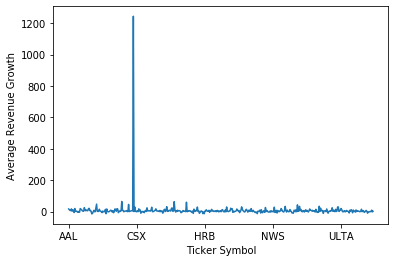

In [6]:
ax = combined['Avg Rev Growth'].plot()
ax.set_ylabel("Average Revenue Growth")

In [7]:
# Remove outlier COTY
reduced = combined.drop(['COTY'])

We see that we've decreased our standard deviation from 59 to 9 — or a reduction of 85% 

In [8]:
reduced['Avg Rev Growth'].describe()

count    447.000000
mean       4.568304
std        9.905012
min      -15.286401
25%       -0.590839
50%        2.656497
75%        7.178388
max       63.911711
Name: Avg Rev Growth, dtype: float64

Convert share price growth feature into a binary target variable for classification


In [9]:

threshold = 0.7
reduced['revGrowthAboveSeven'] = reduced['Avg Rev Growth'].apply(lambda x: 1 if x>threshold else 0)

In [10]:
target = reduced['revGrowthAboveSeven']
features = reduced.drop(columns=['Avg Rev Growth', 'revGrowthAboveSeven', 'Security', 'GICS Sector'])


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=0
)

#### Random Forest

Implement some basic models to predict revenue growth. 

Initialise random forest classifier and train model

In [12]:
randomForestClassifier = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
randomForestClassifier.fit(X_train, y_train)
randomForestClassifier.score(X_train, y_train)

1.0

Calculate accuracy of model using testing data

In [13]:
randomForestClassifier.score(X_test, y_test)

0.6888888888888889

In [14]:
print(classification_report(y_test, randomForestClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.40      0.49        50
           1       0.71      0.86      0.78        85

    accuracy                           0.69       135
   macro avg       0.67      0.63      0.63       135
weighted avg       0.68      0.69      0.67       135



Feature importance from model and display top 10 features. This will demonstrate which features in our data set are driving our models performance most heavily.

In [15]:
labels = features.columns.values
weights = randomForestClassifier.feature_importances_
top_features = sorted(list(zip(labels,weights)), reverse=True, key = lambda x: abs(x[1]))[0:10]
top_labels = [x[0] for x in top_features]
top_weights = [x[1] for x in top_features]
pp.pprint(top_labels)
pp.pprint(top_weights)

[   'Liabilities',
    'Non-Recurring Items',
    'Accounts Receivable',
    'Common Stocks',
    'Retained Earnings',
    'Net Cash Flows-Financing',
    'Other Investing Activities',
    'Other Equity',
    'Changes in Inventories',
    'Estimated Shares Outstanding']
[   0.04349394113042381,
    0.03727946501207849,
    0.034258370229562914,
    0.02853588839847605,
    0.02714328673519921,
    0.025938095968746938,
    0.025565326210729076,
    0.020935844159739307,
    0.01989589195803917,
    0.0196761865505012]


## Gradient boosting

In [16]:
gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=200, random_state=0)
gradientBoostingClassifier.fit(X_train, y_train)
gradientBoostingClassifier.score(X_train, y_train)

1.0

In [17]:
gradientBoostingClassifier.score(X_test, y_test)

0.7185185185185186

In [18]:
print(classification_report(y_test, gradientBoostingClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.46      0.55        50
           1       0.73      0.87      0.80        85

    accuracy                           0.72       135
   macro avg       0.70      0.67      0.67       135
weighted avg       0.71      0.72      0.70       135



#### Include GICS Sector

Added an additional data point to associate each comapny with their GICS Sector. Unlike the rest of the data, this data is presented as text. Both random forests and gradient boosting allow converting categorical data into numbers so that it can be considered by the model.

In [19]:
# We can see that there are only 11 industries and all except Telecommunications Services have at least 20 companies.

reduced.groupby('GICS Sector').count()['Accounts Payable']

GICS Sector
Consumer Discretionary         79
Consumer Staples               32
Energy                         31
Financials                     53
Health Care                    49
Industrials                    62
Information Technology         61
Materials                      24
Real Estate                    27
Telecommunications Services     5
Utilities                      24
Name: Accounts Payable, dtype: int64

Analysing the average growth per GICS Sector we see that comsumer staples outperforms other GICS Sectors.

In [2]:
industryGrouped = reduced.groupby(by=["GICS Sector"]).mean()
industryGrouped
industryGrouped.plot.bar(y='Avg Rev Growth')

NameError: name 'reduced' is not defined

Represent each industry as a number so that it can be used by our models as a data point.

In [21]:
features['Industry'] = pd.factorize(reduced['GICS Sector'])[0]


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=0
)

We repeat the experiment and compare the results now that we have included GICS Sector as a data point. We note that the random forest model has increased its weighted F1 score by three however the F1 score for boosting has remained constant. An increase of three to 71 is only a modest improvement and there are still opportunities to investigate increasing it further. To see how well you understand random forests and gradient boosting, can you think of any reasons why the increase in performance was greater for random forests than for gradient boosting when we introduced 'GICS Sector'?

Random Forest

In [23]:
randomForestClassifier = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
randomForestClassifier.fit(X_train, y_train)
randomForestClassifier.score(X_train, y_train)


1.0

In [24]:
gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=200, random_state=0)
gradientBoostingClassifier.fit(X_train, y_train)
gradientBoostingClassifier.score(X_train, y_train)
gradientBoostingClassifier.score(X_test, y_test)
print(classification_report(y_test, randomForestClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        50
           1       0.71      0.88      0.79        85

    accuracy                           0.70       135
   macro avg       0.69      0.64      0.64       135
weighted avg       0.70      0.70      0.68       135



Gradient Boosting

In [25]:
gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=200, random_state=0)
gradientBoostingClassifier.fit(X_train, y_train)
gradientBoostingClassifier.score(X_train, y_train)
print(classification_report(y_test, gradientBoostingClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.46      0.57        50
           1       0.74      0.91      0.81        85

    accuracy                           0.74       135
   macro avg       0.74      0.68      0.69       135
weighted avg       0.74      0.74      0.72       135

